# Static structure factor in halide perovskite (CsPbI3)

The static structure factor $S(q)$, which is what is measured in diffraction experiments, is commonly used to identify and the determine the crystal structure of a sample.

In this example we will analyze the static structure factor in the halide perovskite CsPbI3, which undergo phase transitions from cubic (high-temperature), to tetragonal (intermediate temperatures) and to orthorhombic (low temperatures).

## Structure and potential files
The relevant structure and potential files for carrying out this analyis can be found in the following  [zenodo repository](https://zenodo.org/records/8014365).
For example you can fetch files via

```
wget https://zenodo.org/records/8014365/files/CsPbI3-CX-cubic-Pm-3m.xyz
wget https://zenodo.org/records/8014365/files/CsPbI3-CX-tetragonal-P4mbm.xyz
wget https://zenodo.org/records/8014365/files/nep-CsPbI3-CX.txt
```

##  MD simulations
The MD simulations analyzed here are run with [GPUMD](https://gpumd.org/) and the `nep.txt` mentioned above.
The MD files (including the trajectories) can be fetched directly from [zenodo MD runs](https://zenodo.org/records/10149722).


In [1]:
import numpy as np
import matplotlib.pyplot as plt
from ase.io import read, write
from dynasor.qpoints import get_spherical_qpoints
from dynasor import compute_static_structure_factors, Trajectory
from dynasor.post_processing import get_gaussian_spherical_averaged_sample

## S(q) for ideal structures
First we  compute the structure factor, $S(q)$, for the ideal CsPbI3 structures.
Here, we normalize $S(q)$ by number of atoms to more easily compare $S(q)$ for structures with varying number of atoms.


For the cubic phase we expect peaks at the q-points $\boldsymbol{q}=\frac{2\pi}{a}[i, j, k]$ for interger values for i, j, k.
The cubic lattice parameter, $a=6.26$Å, is numerical quite close to $2\pi$ meaning $S(q)$ will exhibit peaks for the cubic phase at about $q=1.0, \sqrt{2}, \sqrt{3}, 2.0$ $Å^{-1}$  corresponding to $\boldsymbol{q}=[1,0,0] , [1, 1, 0], [1, 1, 1], [2, 0, 0]$.

In the tetragonal phase the x, y, z cubic symmetry is broken and z become distinct from x and y. This means that e.g. the degenerate peaks $[1, 0, 0], [0, 1, 0], [0, 0, 1]$ in the cubic phase splits into two peaks.
Furthermore, since the tetragonal phase arises from a soft phonon mode instability at the M-point ($[0.5, 0.5, 0]$), we expect additional peaks at e.g. $q=1.58$ ($[1.5, 0.5, 0]$) and $q=1.87$ ($[1.5, 0.5, 1]$).


To demonstrate this point we also mark these expected q-points in the figure below wih dashed gray lines. Note that in order to get perfect agreement with the calculated $S(q)$ of the real structure one would need to take into account the exact lattice-parameters.

In [2]:
structure_tags = ['CsPbI3-CX-tetragonal-P4mbm', 'CsPbI3-CX-cubic-Pm-3m']
data_dict = dict()
for structure_tag in structure_tags:

    # write dummy traj
    atoms = read(f'{structure_tag}.xyz')
    atoms.calc = None
    n_atoms = len(atoms)
    traj = [atoms for _ in range(2)]
    write('tmp_traj.xyz', traj)

    # setup traj
    traj = Trajectory('tmp_traj.xyz', trajectory_format='extxyz', atomic_indices="read_from_trajectory")

    # q-points
    q_max = 2.5
    q_points = get_spherical_qpoints(traj.cell, q_max=q_max)

    # compute Sq
    sample = compute_static_structure_factors(traj, q_points)
    q_norms = np.linalg.norm(sample.q_points, axis=1)
    data_dict[structure_tag] = q_norms, sample.Sq / n_atoms

INFO: Trajectory file: tmp_traj.xyz
INFO: Total number of particles: 10
INFO: Number of atom types: 3
INFO: Number of atoms of type Cs: 2
INFO: Number of atoms of type I: 6
INFO: Number of atoms of type Pb: 2
INFO: Simulation cell (in Angstrom):
[[8.62193057 0.         0.        ]
 [0.         8.62193057 0.        ]
 [0.         0.         6.37484774]]
INFO: Number of q-points: 30
INFO: Trajectory file: tmp_traj.xyz
INFO: Total number of particles: 5
INFO: Number of atom types: 3
INFO: Number of atoms of type Cs: 1
INFO: Number of atoms of type I: 3
INFO: Number of atoms of type Pb: 1
INFO: Simulation cell (in Angstrom):
[[6.25796103 0.         0.        ]
 [0.         6.25796103 0.        ]
 [0.         0.         6.25796103]]
INFO: Number of q-points: 20


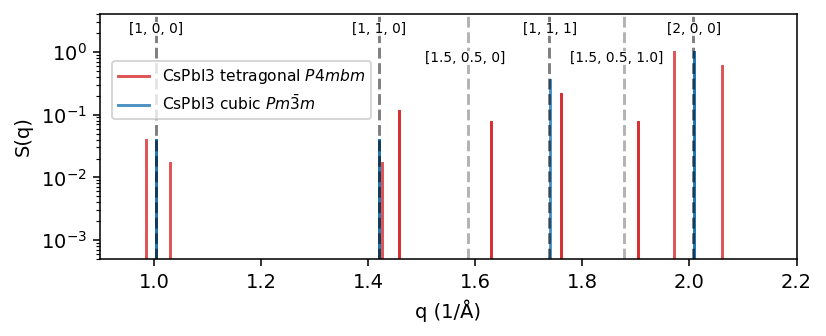

In [3]:
# plot setup
fig = plt.figure(figsize=(6.0, 2.5), dpi=140)
ax1 = fig.add_subplot()

colors = dict()
colors['CsPbI3-CX-tetragonal-P4mbm'] = 'tab:red'
colors['CsPbI3-CX-cubic-Pm-3m'] = 'tab:blue'

labels = dict()
labels['CsPbI3-CX-tetragonal-P4mbm'] = r'CsPbI3 tetragonal $P4mbm$'
labels['CsPbI3-CX-cubic-Pm-3m'] = r'CsPbI3 cubic $Pm\bar{3}m$'

xlim = [0.9, 2.2]
ylim = [0.0005, 4]
alpha = 0.8


# plot S(q) as vertical lines
for structure_tag, (q_norms, Sq) in data_dict.items():
    for q, S in zip(q_norms, Sq):    
        ax1.plot([q, q], [0, S[0]], color=colors[structure_tag], alpha=alpha)
    ax1.plot(np.nan, np.nan, color=colors[structure_tag], alpha=alpha, label=labels[structure_tag])


# Mark the cubic gamma-points
alat = 6.26
alpha = 0.5
fs = 7
bbox = dict(facecolor='w', edgecolor='none', alpha=0.85, pad=0.0)

q_vecs = [[1, 0, 0], [1, 1, 0], [1, 1, 1], [2, 0, 0]]
for qvec in q_vecs:
    q = 2 * np.pi / alat * np.linalg.norm(qvec)
    ax1.axvline(x=q, ls='--', color='k', alpha=alpha)
    ax1.text(q -0.05, 0.5 * ylim[-1], str(qvec), fontsize=fs, bbox=bbox)

# Mark the cubic M-points
qvec_M1 = [1.5, 0.5, 0]
qvec_M2 = [1.5, 0.5, 1.0]
q_M1 = 2 * np.pi / alat * np.linalg.norm(qvec_M1)
q_M2 = 2 * np.pi / alat * np.linalg.norm(qvec_M2)
ax1.axvline(x=q_M1, ls='--', color='k', alpha=alpha-0.2)
ax1.axvline(x=q_M2, ls='--', color='k', alpha=alpha-0.2)
ax1.text(q_M1-0.08, 0.17 * ylim[-1], str(qvec_M1), fontsize=fs, bbox=bbox)
ax1.text(q_M2-0.1, 0.17 * ylim[-1], str(qvec_M2), fontsize=fs, bbox=bbox)


ax1.set_xlim(xlim)
ax1.set_ylim(ylim)
ax1.set_yscale('log')
ax1.legend(loc=1, fontsize=8, bbox_to_anchor=(0.4, 0.84))
ax1.set_xlabel('q (1/Å)')
ax1.set_ylabel('S(q)')

fig.tight_layout()

## S(q) from MD simulations
When running MD simulations of larger supercells, the number of available q-points become large.
Here, we can either sample selective q-points in specific regions of the BZ, see e.g. [this paper](https://arxiv.org/abs/2310.05565).     

Alternativley, we can sample all of the avaiable q-points and e.g. conduct a spherical q-point average in order to mimic experimental powder diffraction data.

### Spherical q-point average
Spherical q-point averaging can be done in dynasor with the `compute_spherical_qpoint_average` function using either a binning method or Gaussian smearing method, here we use the latter meaning
\begin{equation}
S(q) = \sum_i w(\boldsymbol{q}_i, q) S(\boldsymbol{q}_i)
\end{equation}
where $w(\boldsymbol{q}_i, q)$ is a Gaussian weight, i.e.
\begin{equation}
w(\boldsymbol{q}_i, q) \propto \exp{\left [ -\frac{1}{2} \left ( \frac{|\boldsymbol{q}_i| - q}{q_{width}} \right)^2 \right ]}
\end{equation}

Below we compute and plot the raw $S(q)$ and the Gaussian spherical averaged $S(q)$ for one selected MD simulation to demonstrate it.
One can play around with the width (standard deviation) of the Gaussian, `q_width`, in order to obtain a desirable looking structure factor.

In [4]:
# parameters
q_max = 2.2
q_linspace = np.linspace(0, q_max, 1000)
q_width = 0.1

# setup traj
tag = f'tetra_size8_T450_nframes1000'
dirname = f'md_runs/NVT_{tag}/'
traj = Trajectory(dirname + 'movie.nc', trajectory_format='nc')

# generate all q-points in supercell
q_points = get_spherical_qpoints(traj.cell, q_max=q_max)

# compute Sq
sample = compute_static_structure_factors(traj, q_points)

INFO: Trajectory file: md_runs/NVT_tetra_size8_T450_nframes1000/movie.nc
INFO: Total number of particles: 5120
INFO: Number of atom types: 1
INFO: Number of atoms of type X: 5120
INFO: Simulation cell (in Angstrom):
[[70.64849   0.        0.      ]
 [ 0.       70.64849   0.      ]
 [ 0.        0.       50.730995]]
INFO: Number of q-points: 6288


In [5]:
# spherical average over q-points
data_dict_qwidths = dict()
for q_width in [0.001, 0.005, 0.02]:

    sample_averaged = get_gaussian_spherical_averaged_sample(sample, q_norms=q_linspace, q_width=q_width)
    data_dict_qwidths[q_width] = sample_averaged.q_norms, sample_averaged.Sq

It can be useful to visualize the static structure factor both on a linear and a log y-scale.

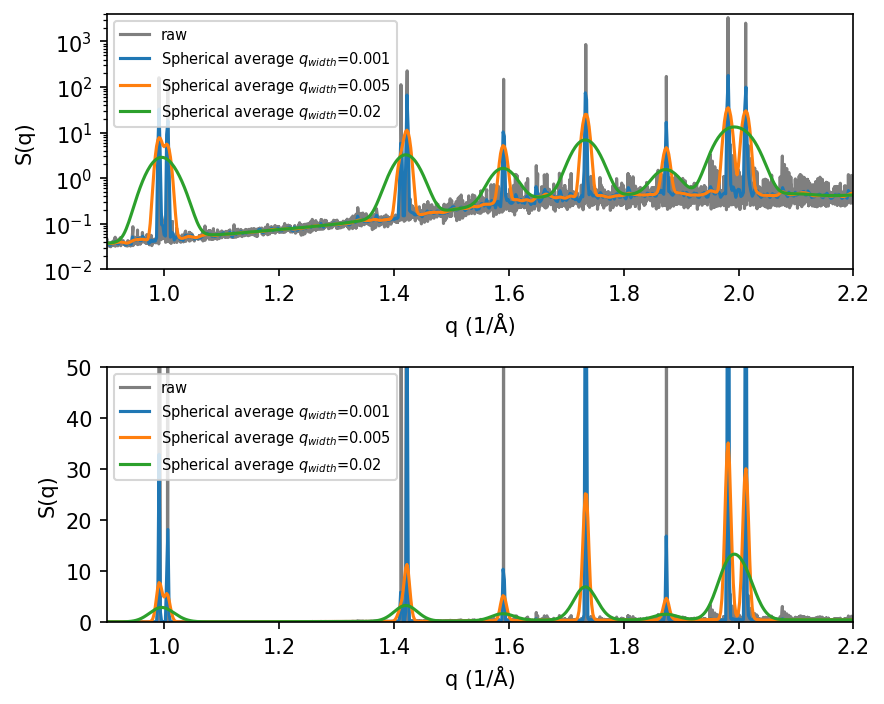

In [6]:
fig = plt.figure(figsize=(6.0, 4.8), dpi=150)
ax1 = fig.add_subplot(211)
ax2 = fig.add_subplot(212)

for ax, log_yscale in zip([ax1, ax2], [True, False]):

    # plotting of raw S(q)
    q_norms = np.linalg.norm(sample.q_points, axis=1)
    ax.plot(q_norms, sample.Sq, '-k', alpha=alpha, label='raw')

    # plotting of gaussian spherical average S(q)
    for q_width, (q, Sq) in data_dict_qwidths.items():
        ax.plot(q, Sq, '-', label=rf'Spherical average $q_{{width}}$={q_width}')

    ax.set_xlabel('q (1/Å)')
    ax.set_ylabel('S(q)')
    ax.set_xlim(xlim)
    ax.legend(loc=2, fontsize=7)
    if log_yscale:
        ax.set_yscale('log')
        ax.set_ylim(0.01, 4000)
    else:
        ax.set_ylim(0.0, 50)

fig.tight_layout()

Note, that the position of the peaks in the static structure factor, $S(q)$, obtained from MD agrees perfectly with the peaks obtained from the ideal tetragonal structure.

### Convergence with respect to number trajectory length
First, we analyze the static structure factor for a 8x8x8 tetragonal cell as a function of the simulation length (number of snapshots in the trajectory).

We analyze parts of the trajectory using 10, 100, and 1000 snapshots.
The resulting S(q) looks quite converged already for 10-100 snapshots.

In [7]:
q_width = 0.001
n_frames_vals = [10, 100, 1000]
data_dict_nframes = dict()
for n_frames in n_frames_vals:
    print('Running nframes', n_frames)

    # setup traj
    tag = f'tetra_size8_T450_nframes1000'
    dirname = f'md_runs/NVT_{tag}/'
    traj = Trajectory(dirname + 'movie.nc', trajectory_format='nc', frame_stop=n_frames)

    # generate all q-points in supercell
    q_points = get_spherical_qpoints(traj.cell, q_max=q_max)

    # compute Sq
    sample = compute_static_structure_factors(traj, q_points)
    sample_averaged = get_gaussian_spherical_averaged_sample(sample, q_norms=q_linspace, q_width=q_width)
    data_dict_nframes[n_frames] = sample_averaged.q_norms, sample_averaged.Sq

Running nframes 10
INFO: Trajectory file: md_runs/NVT_tetra_size8_T450_nframes1000/movie.nc
INFO: Total number of particles: 5120
INFO: Number of atom types: 1
INFO: Number of atoms of type X: 5120
INFO: Simulation cell (in Angstrom):
[[70.64849   0.        0.      ]
 [ 0.       70.64849   0.      ]
 [ 0.        0.       50.730995]]
INFO: Number of q-points: 6288
Running nframes 100
INFO: Trajectory file: md_runs/NVT_tetra_size8_T450_nframes1000/movie.nc
INFO: Total number of particles: 5120
INFO: Number of atom types: 1
INFO: Number of atoms of type X: 5120
INFO: Simulation cell (in Angstrom):
[[70.64849   0.        0.      ]
 [ 0.       70.64849   0.      ]
 [ 0.        0.       50.730995]]
INFO: Number of q-points: 6288
Running nframes 1000
INFO: Trajectory file: md_runs/NVT_tetra_size8_T450_nframes1000/movie.nc
INFO: Total number of particles: 5120
INFO: Number of atom types: 1
INFO: Number of atoms of type X: 5120
INFO: Simulation cell (in Angstrom):
[[70.64849   0.        0.     

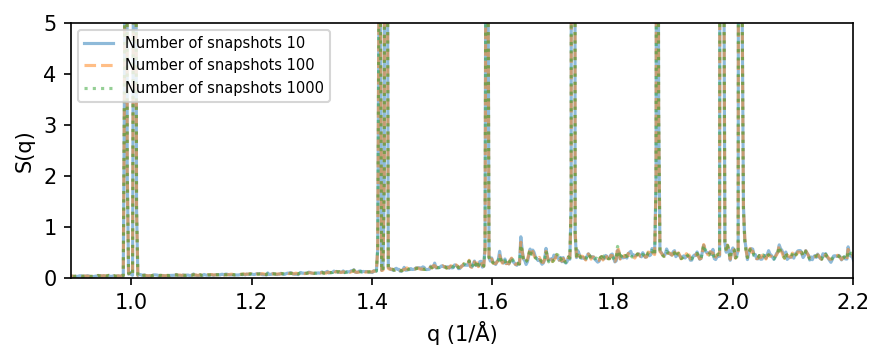

In [8]:
# plot setup
fig = plt.figure(figsize=(6.0, 2.5), dpi=150)
ax1 = fig.add_subplot(111)
ylim = [2e-2, 5000]
alpha = 0.5

# plotting
linestyles = dict()
linestyles[10] = '-'
linestyles[100] = '--'
linestyles[1000] = ':'
for n_frames, (q, Sq) in data_dict_nframes.items():
    ax1.plot(q, Sq, ls=linestyles[n_frames], label=f'Number of snapshots {n_frames}', alpha=alpha)
ax1.set_xlabel('q (1/Å)')
ax1.set_ylabel('S(q)')

ax1.set_xlim(xlim)
ax1.set_ylim(0, 5)
#ax1.set_yscale('log')
ax1.legend(loc=2, fontsize=7)   

fig.tight_layout()
plt.show()

### Convergence with respect to system size
Next, we look at how S(q) converges with respect to system size in the MD simulation. For larger supercells the number of q-points become larger meaning the calculations will be slower. Running the last calculation, `size=12`, can take a few minutes.

In [9]:
q_width = 0.001
size_vals = [4, 8, 12]
data_dict_sizes = dict()
for size in size_vals:
    print('Running size', size)

    # setup traj
    tag = f'tetra_size{size}_T450_nframes1000'
    dirname = f'md_runs/NVT_{tag}/'
    traj = Trajectory(dirname + 'movie.nc', trajectory_format='nc')

    # generate all q-points in supercell
    q_points = get_spherical_qpoints(traj.cell, q_max=q_max)

    # compute Sq
    sample = compute_static_structure_factors(traj, q_points)
    sample_averaged = get_gaussian_spherical_averaged_sample(sample, q_norms=q_linspace, q_width=q_width)
    data_dict_sizes[size] = sample_averaged.q_norms, sample_averaged.Sq

Running size 4
INFO: Trajectory file: md_runs/NVT_tetra_size4_T450_nframes1000/movie.nc
INFO: Total number of particles: 640
INFO: Number of atom types: 1
INFO: Number of atoms of type X: 640
INFO: Simulation cell (in Angstrom):
[[35.324245  0.        0.      ]
 [ 0.       35.324245  0.      ]
 [ 0.        0.       25.365498]]
INFO: Number of q-points: 865
Running size 8
INFO: Trajectory file: md_runs/NVT_tetra_size8_T450_nframes1000/movie.nc
INFO: Total number of particles: 5120
INFO: Number of atom types: 1
INFO: Number of atoms of type X: 5120
INFO: Simulation cell (in Angstrom):
[[70.64849   0.        0.      ]
 [ 0.       70.64849   0.      ]
 [ 0.        0.       50.730995]]
INFO: Number of q-points: 6288
Running size 12
INFO: Trajectory file: md_runs/NVT_tetra_size12_T450_nframes1000/movie.nc
INFO: Total number of particles: 17280
INFO: Number of atom types: 1
INFO: Number of atoms of type X: 17280
INFO: Simulation cell (in Angstrom):
[[105.97274   0.        0.     ]
 [  0.     

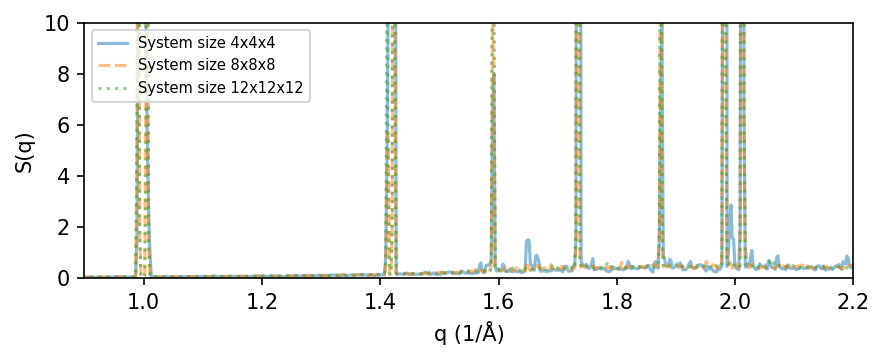

In [10]:
# plot setup
fig = plt.figure(figsize=(6.0, 2.5), dpi=150)
ax1 = fig.add_subplot(111)
ylim = [2e-2, 5000]
alpha = 0.5

# plotting
linestyles = dict()
linestyles[4] = '-'
linestyles[8] = '--'
linestyles[12] = ':'
for size, (q, Sq) in data_dict_sizes.items():
    ax1.plot(q, Sq, ls=linestyles[size], label=f'System size {size}x{size}x{size}', alpha=alpha)
ax1.set_xlabel('q (1/Å)')
ax1.set_ylabel('S(q)')

ax1.set_xlim(xlim)
ax1.set_ylim(0, 10)
#ax1.set_yscale('log')
ax1.legend(loc=2, fontsize=7)   

fig.tight_layout()
plt.show()

### Decomposing S(q) by atom types
So far we have only considered the total $S(q)$, but one can also decompose $S(q)$ for the various atom types in the system and compute the partial structure factors $S_{\alpha \beta}$.

\begin{equation}
S_{\alpha \beta}(\boldsymbol{q}) = \frac{1}{N} \left < \sum_{i \in \alpha} ^{N_\alpha} \sum_{j \in \beta}^{N_\beta} \exp{\left [ i\boldsymbol{q}\cdot (\boldsymbol{r}_i(t) - \boldsymbol{r}_j(t)) \right ]} \right >,
\end{equation}

where $\alpha$ and $\beta$ are different atom types, and $N$ the total number of atoms, see the [dynasor documentation](https://dynasor.materialsmodeling.org/theory.html#multi-component-systems) for more details on e.g. normalization.

Analyzing the partial structure factors can be useful in order to understand the origin of features and peaks in $S(q)$, see e.g. [this paper](https://arxiv.org/abs/2310.05565).
Specifically, for CsPbI$_3$ we know that it is displacements of the iodine atoms that give rise to the cubic to tetragonal phase transition, as we can clearly see below.

In order to compute the partial structure factors we need to specify `atomic_indices` in the `Trajectory`. 
By setting for example `atomic_indices='read_from_trajectory'` means the atomic types will be read directly from the trajectory, however this does not work for netcdf trajectories used in this tutorial.
Instead we create a dict containing the atomic indices for each unique atom type using the input `model.xyz` file from which the MD simulations were started.

In [11]:
q_width = 0.001
tag = f'tetra_size8_T450_nframes1000'
dirname = f'md_runs/NVT_{tag}/'

# read atomic indices
atoms_ideal = read(dirname + 'model.xyz')
atomic_indices = atoms_ideal.symbols.indices()
for atom_type, indices in atomic_indices.items():
    print(f'{atom_type}: num atoms {len(indices)}')

# setup traj
traj = Trajectory(dirname + 'movie.nc', trajectory_format='nc', atomic_indices=atomic_indices)

# generate all q-points in supercell
q_points = get_spherical_qpoints(traj.cell, q_max=q_max)

# compute Sq
sample = compute_static_structure_factors(traj, q_points)
sample_averaged = get_gaussian_spherical_averaged_sample(sample, q_norms=q_linspace, q_width=q_width)

Cs: num atoms 1024
Pb: num atoms 1024
I: num atoms 3072
INFO: Trajectory file: md_runs/NVT_tetra_size8_T450_nframes1000/movie.nc
INFO: Total number of particles: 5120
INFO: Number of atom types: 3
INFO: Number of atoms of type Cs: 1024
INFO: Number of atoms of type Pb: 1024
INFO: Number of atoms of type I: 3072
INFO: Simulation cell (in Angstrom):
[[70.64849   0.        0.      ]
 [ 0.       70.64849   0.      ]
 [ 0.        0.       50.730995]]
INFO: Number of q-points: 6288


In [12]:
print(sample_averaged)

StaticSample
Atom types: ['Cs', 'I', 'Pb']
Pairs: [('Cs', 'Cs'), ('Cs', 'I'), ('Cs', 'Pb'), ('I', 'I'), ('I', 'Pb'), ('Pb', 'Pb')]
Particle counts: {'Cs': 1024, 'Pb': 1024, 'I': 3072}
Simulations cell:
[[70.64849   0.        0.      ]
 [ 0.       70.64849   0.      ]
 [ 0.        0.       50.730995]]
Sq              with shape: (1000,)
Sq_Cs_Cs        with shape: (1000,)
Sq_Cs_I         with shape: (1000,)
Sq_Cs_Pb        with shape: (1000,)
Sq_I_I          with shape: (1000,)
Sq_I_Pb         with shape: (1000,)
Sq_Pb_Pb        with shape: (1000,)
q_norms         with shape: (1000,)


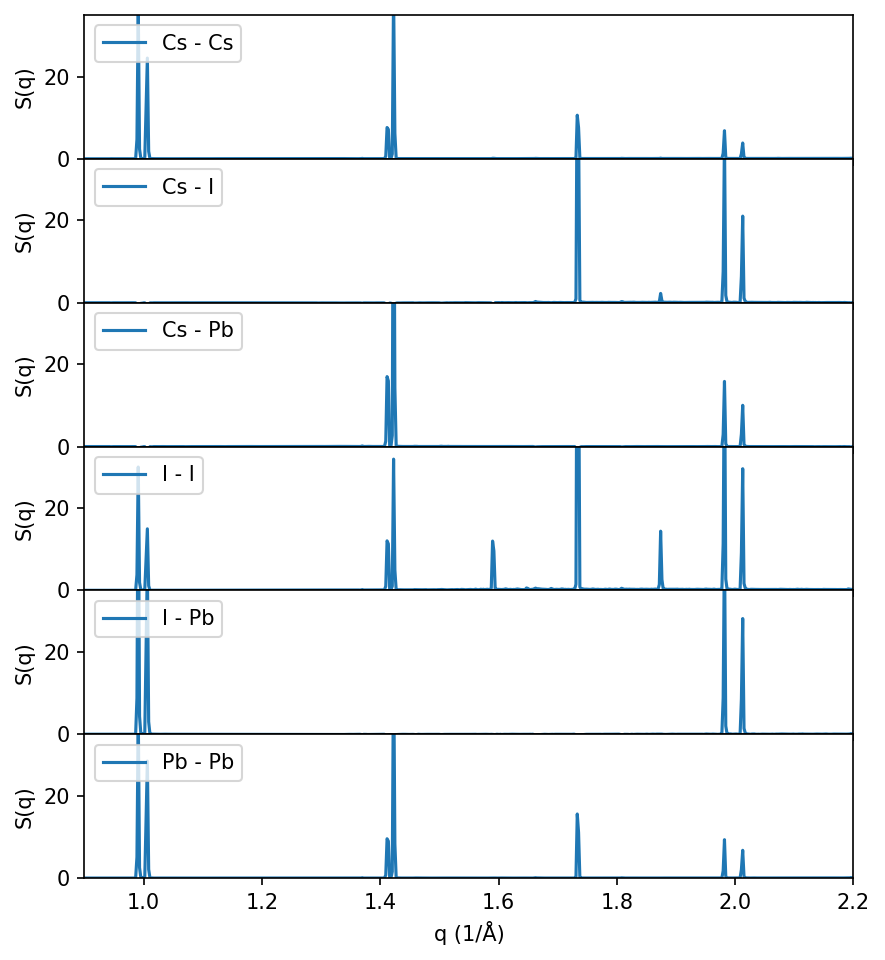

In [13]:
# plot setup
fig, axes = plt.subplots(nrows=6, ncols=1, sharex=True, figsize=(6.0, 6.5), dpi=150)
ylim = [2e-2, 5000]
alpha = 0.5

# plotting
for ax, (atom_type1, atom_type2) in zip(axes, sample_averaged.pairs):
    key = f'Sq_{atom_type1}_{atom_type2}'
    ax.plot(q, sample_averaged[key], '-', label=f'{atom_type1} - {atom_type2}')
    ax.set_ylabel('S(q)')
    ax.set_xlim(xlim)
    ax.set_ylim(0, 35)
    ax.legend(loc=2)   
    #ax.set_yscale('log')
ax.set_xlabel('q (1/Å)')

fig.tight_layout()
fig.subplots_adjust(hspace=0)
plt.show()

Note that the peaks around q=1.6 and q=1.85 (corresponding to the M-point as discussed above) only shows up in the I-I partial structure factor, as expected since the soft phonon mode at the M-point (corresponding to the transition from cubic to tetragonal) only involves I atoms.

## Observing the phase transition in S(q)
Lastly, we show how the structure factor can be used to identify the phase transitions by running multiple simulations at various temperature and visualizing the results as a heatmap.
Here, one can see how the peaks at the M-point (as discussed above) emerges at the phase transition temperature at around T=550K.

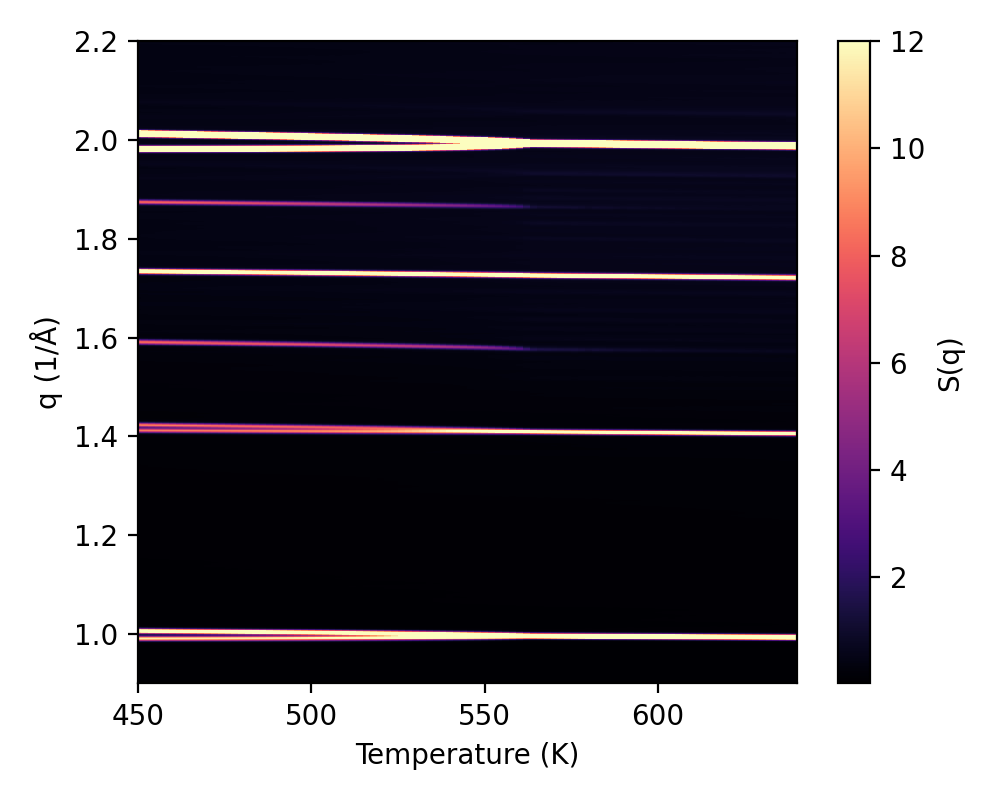
